In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using COSMO
using ECOS
using Random; 

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/rocket_landing_Zac/Project.toml`


    Updating 

registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General`


   Installed CodecZlib ────────── v0.7.4
   Installed ChangePrecision ──── v1.1.0
   Installed ECOS ─────────────── v1.1.1
   Installed TranscodingStreams ─ v0.10.3
   Installed AMD ──────────────── v0.5.3
   Installed ChainRulesCore ───── v1.20.1


   Installed COSMO ────────────── v0.8.8
   Installed CodecBzip2 ───────── v0.8.2
   Installed StaticArrays ─────── v1.9.2
   Installed JuMP ─────────────── v1.19.0


   Installed MathOptInterface ─── v1.25.2


    Updating `~/SSD/Code/Julia/tinympc-julia/rocket_landing_Zac/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.4.0
  [1e616198] + COSMO v0.8.8
  [3cb15238] + ChangePrecision v1.1.0
  [e2685f51] + ECOS v1.1.1
  [6a86dc24] + FiniteDiff v2.22.0
  [4076af6c] + JuMP v1.19.0
    Updating `~/SSD/Code/Julia/tinympc-julia/rocket_landing_Zac/Manifest.toml`
  [14f7f29c] + AMD v0.5.3
  [79e6a3ab] + Adapt v3.7.2
  [4fba245c] + ArrayInterface v7.5.1
  [6e4b80f9] + BenchmarkTools v1.4.0
  [fa961155] + CEnum v0.4.2
  [1e616198] + COSMO v0.8.8
  [bbd8fffe] + COSMOAccelerators v0.1.0
  [d360d2e6] + ChainRulesCore v1.20.1
  [3cb15238] + ChangePrecision v1.1.0
  [9e997f8a] + ChangesOfVariables v0.1.8
  [523fee87] + CodecBzip2 v0.8.2
  [944b1d66] + CodecZlib v0.7.4
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.12.0
  [187b0558] + ConstructionBase v1.5.4
  [864edb3b] + DataStructures v0.18.16
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [ffbed154] + DocStringExt

  [6e34b625] + Bzip2_jll v1.0.8+1
  [c2c64177] + ECOS_jll v200.0.800+0
  [efe28fd5] + OpenSpecFun_jll v0.5.5+0
  [0dad84c5] + ArgTools
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads
  [9fa8497b] + Future
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [a63ad114] + Mmap
  [ca575930] + NetworkOptions
  [44cfe95a] + Pkg
  [de0858da] + Printf
  [9abbd945] + Profile
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA
  [9e88b42a] + Serialization
  [6462fe0b] + Sockets
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
  [4607b0f0] + SuiteSparse
  [fa267f1f] + TOML
  [a4e569a6] + Tar
  [8dfed614] + Test
  [cf7118a7] + UUIDs
  [4ec0a83e] + Unicode
  [e66e0078] + CompilerSupportLibraries_jll
  [deac9b47] + LibCURL_jll
  [29816b5a] + LibSSH2_jll
  [c8ffd9c3] + MbedTLS_jll
  [14a3606d] + MozillaCACerts_jll
  [45

In [2]:
# Let's solve TrajOpt first
include("mpc_JuMP.jl")
include("tinyMPC.jl")

affine = 1  # SOLVE AFFINE DYNAMICS

A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]*affine
# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    # State is x, y, z, vx, vy, vz
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f*affine
end

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 10e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

gravity = [0; 0; -9.81]
mass = 10.0
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax

# Sloppy bound to test
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# Sloppy bound to test
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*1  # Replace 1 with 0 to ignore this constraint
ncu = 2*nu*1
ncg = 1
ncu_cone = nu*0;  # Not used now
cone_scale = 1e-3  

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
uguess = [0; 0; 100.0]
U = [deepcopy(uguess) for k = 1:N-1]  # initial guess 
# new iterate

Xn = deepcopy(X)
Un = deepcopy(U)
P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "rho"=>1e-2,
        "scaling"=>0,
        "alpha"=>1.0),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false,
        "feastol"=>1e-4,
        "abstol"=>1e-4,
        "reltol"=>1e-4)) 

# Solve with other solver
# mpc_JuMP(optimizers[1], params, Xn, Un, A, B, f; warm_start=false)

# Solve with tinyMPC
u_ = tiny_solve!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,max_inner_iters=10, verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0);

ΔJ = 595.6418152952101
ΔJ = 2.9792783444281667
ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    1.329e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00


convio = 47.01680822168961
ΔJ = 14672.902957835235
ΔJ = 2777.083365086466
ΔJ = 14.17279899935238
ΔJ = 0.0
  2    1.355e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 29.813217261444287
ΔJ = 39930.40026758821
ΔJ = 72609.78294609301
ΔJ = 

2866.6112991576083
ΔJ = 2.4860617604572326
ΔJ = 0.0
  3    1.403e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 14.079706213310454
ΔJ = 10622.107545429375
ΔJ = 121155.11184335523
ΔJ = 972.4363075539004
ΔJ = 2.385795142268762
ΔJ = 0.0
  4    1.469e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 8.699420636610062
ΔJ = 

275518.9360845261
ΔJ = -171718.53180575348
ΔJ = 163029.01467027212
ΔJ = 12956.584189470857
ΔJ = 48.608486101729795
ΔJ = 0.0
  5    1.540e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+04
convio = 1.749120084825382
ΔJ = -856018.5257803735


ΔJ = -506245.250517678
ΔJ = 1.4741556594782472e6
ΔJ = 10586.581818119157
ΔJ = -288.9771647283342
ΔJ = 375.0566890495829
ΔJ = 24.87875750544481
ΔJ = 19.549895412987098
ΔJ = 14.098285597283393


ΔJ = -108.62262188596651
  6    1.555e+06  -1.09e+02   0.00e+00  1.0000    1.00e-08    1.00e+05
convio = 0.19224215820761176
ΔJ = 16119.603928664932
ΔJ = -123.69527243543416
ΔJ = 127.20800490863621
ΔJ = 1.0830416632816195
ΔJ = 0.7460997302550822
  7    1.557e+06   7.46e-01   0.00e+00  1.0000    1.00e-08    1.00e+06
convio = 0.019583583153699846
ΔJ = 1554.1176116999704
ΔJ = 0.23814735398627818
  8    1.557e+06   2.38e-01   0.00e+00  1.0000    1.00e-08    1.00e+07
convio = 

0.001961641197970654
ΔJ = 156.1429217616096
ΔJ = -909.5326889546122
ΔJ = 909.8417677220423
ΔJ = 0.082688610535115
  9    1.557e+06   8.27e-02   0.00e+00  1.0000    1.00e-08    1.00e+08
convio = 0.00019619644742635556
ΔJ = 15.933231637114659
ΔJ = -0.056099298410117626
ΔJ = 0.13800646387971938
 10    1.557e+06   1.38e-01   0.00e+00  1.0000    1.00e-08    1.00e+09
convio = 1.9619952347893488e-5


┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/bMtsB/src/backends.jl:43


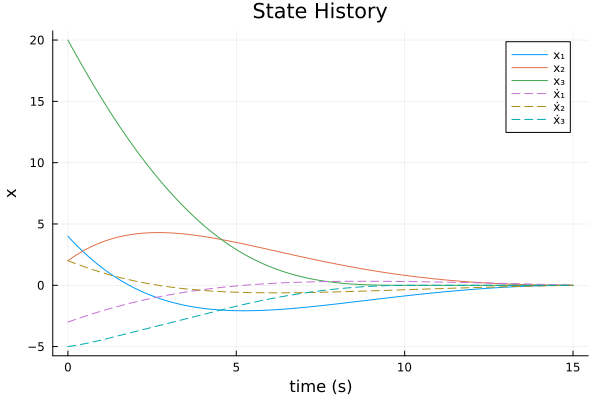

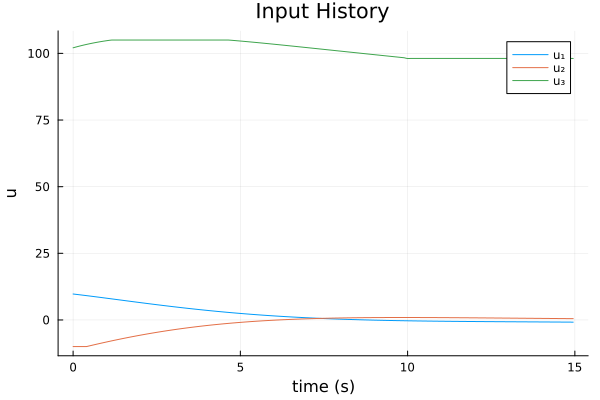

In [3]:
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

In [4]:
@show params.λ'*X[N]
X[N]
# params.μx
convio = 0.0
if params.ncx > 0
  for k = 1:N
    hxv = ineq_con_x(params,X[k])
    mask = eval_mask(μx[k],hxv)
    # update dual
    convio = max(convio,norm(hxv + abs.(hxv),Inf)) 
    @show params.μx[k]'*hxv  # Test Complementarity         
  end
end

(params.λ)' * X[N] = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv =

In [5]:
# Reference for the next MPC problem
Xref .= Xn;
Uref .= Un;

In [6]:
### MPC Problem ###
include("mpc_JuMP.jl")
include("tinyMPC.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]
xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)
R = 1e-1*I(nu)
Qf = 100*I(nx)

θ_thrust_max = 5.0  # deg
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]

u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0;  # Not used now 
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:Nh-1]   # input constraints
μx = [zeros(ncx) for i = 1:Nh]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:Nh-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref[1:Nh],
    Uref = Uref[1:Nh-1],
    dt = dt,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = deepcopy(Uref)

# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
# uguess = [0; 0; 100.0]
U = [Uref[k] for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)

Random.seed!(1); 
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i-2], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i] 
    
    Uhist[i] .= mpc_JuMP(optimizer, params1, X, U, A, B, f; warm_start=false)
    
    # Uhist[i] .= tiny_solve!(params1,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,max_inner_iters=10, verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0);
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
    shift_fill(U)
end

tinyMPC is much faster than COSMOS

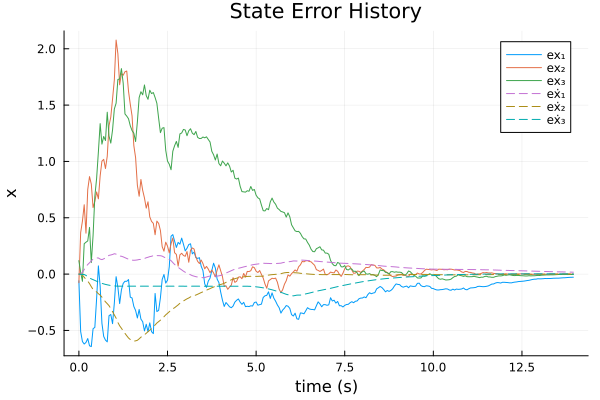

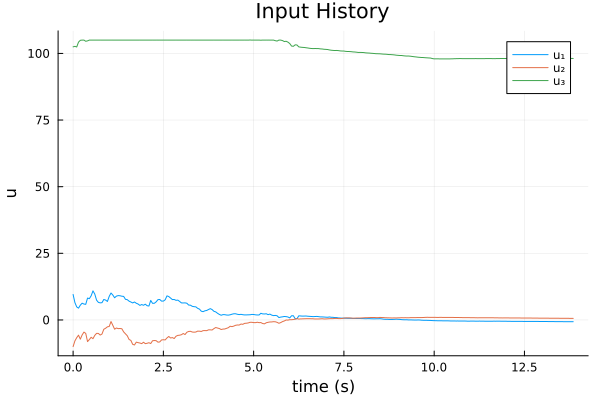

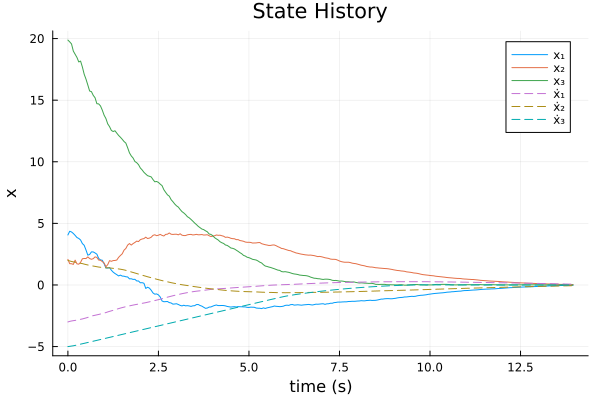

traj_error = maximum(norm.(e_sim_m, Inf)) = 2.077375904066952


In [7]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))